# Experiments on the data of Grand et al

## Loading stuff

In [1]:
import os
from scipy import stats
import numpy as np 
import pandas as pd
import zipfile
import math
import sklearn
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

glove_path = "glove/glove.42B.300d.zip"
glove_file = "glove.42B.300d.txt"

feature_dim = 300

word_vectors = { }

with zipfile.ZipFile(glove_path) as azip:
    with azip.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode()
            vector = np.array(values[1:], dtype=np.float32)
            word_vectors[word] = vector

grandratings_dir = "Grand_etal_csv/"
grandfeatures_path = "/Users/kee252/Data/grand_directions_in_space/features.xlsx"

grandfeatures_df = pd.read_excel(grandfeatures_path)

# reading in Grand data
def read_grand_data(filename, grandratings_dir, grandfeatures_df):
    # extract category and feature
    grandcategory, grandfeature = filename[:-4].split("_")
        
    # read human ratings, make gold column
    df = pd.read_csv(grandratings_dir + filename)
    nspeakers = len(df.columns) -1
    df["Average"] = [row.iloc[1:26].sum() / nspeakers for _, row in df.iterrows()]
    # z-scores of average ratings
    df["Gold"] = (df["Average"] - df["Average"].mean()) / df["Average"].std()
        
    # obtain seed words from excel file
    relevant_row = grandfeatures_df[grandfeatures_df.Dimension == grandfeature]
    seedwords = relevant_row.iloc[:, 1:].values.flatten().tolist()
    pos_seedwords = seedwords[:3]
    neg_seedwords = seedwords[3:]
    
    return (grandcategory, grandfeature, pos_seedwords, neg_seedwords, df)

/Users/kee252/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Reproducing their results

We reproduce their results from the Nature paper almost perfectly, on both Pearson's r correlation and pairwise order evaluation OC_P. X percent of category/feature pairs show a significant correlation, and average OC_P is Y.

In [2]:
# script for running on data
def each_grandcondition(grandratings_dir, grandfeatures_df):
    for filename in os.listdir(grandratings_dir): 
        if not filename.endswith("csv"):
            continue

        grandcategory, grandfeature, pos_seedwords, neg_seedwords, df = read_grand_data(filename, 
                                                                    grandratings_dir, 
                                                                    grandfeatures_df)

        # storage for word vectors and gold values for this dataset
        data_vectors = []

        # collect word vectors and gold ratings
        for row in df.itertuples():
            # row.Row is the word. look it up in word_vectors
            data_vectors.append( word_vectors[ row.Row ])
            
        yield (grandcategory, grandfeature, pos_seedwords, neg_seedwords, df, data_vectors)


In [3]:
import compute_dim
import eval_dim
from scipy import stats

results = [ ]

for grandcategory, grandfeature, pos_seedwords, neg_seedwords, df, data_vectors in each_grandcondition(grandratings_dir, grandfeatures_df):
    
    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
    
    df["Pred"]  = compute_dim.predict_scalarproj(data_vectors, dimension)
    
    ocp = eval_dim.pairwise_order_consistency(df["Gold"], df["Pred"])
    result_obj = stats.pearsonr(df["Gold"], df["Pred"])
    
    results.append({"category": grandcategory,
                    "feature" : grandfeature,
                    "ocp" : ocp,
                    "pearsonr" : result_obj.statistic,
                    "pvalue" : result_obj.pvalue } )
    

In [4]:
# arranging the data in the same order as in the Grand et al paper so we can compare numbers

for r in sorted(results, key = lambda r:(r["feature"], r["category"])):
    starred = "*" if r["pearsonr"] > 0 and r["pvalue"] < 0.05 else ""
    print(r["category"], r["feature"], 
          "r", round(r["pearsonr"], 3), "p=", round(r["pvalue"],3), 
          "ocp", round(r["ocp"], 3), " ", starred)

clothing age r 0.561 p= 0.0 ocp 0.709   *
names age r 0.616 p= 0.0 ocp 0.723   *
professions age r 0.238 p= 0.1 ocp 0.568   
cities arousal r 0.001 p= 0.996 ocp 0.522   
clothing arousal r 0.185 p= 0.199 ocp 0.562   
professions arousal r 0.523 p= 0.0 ocp 0.658   *
sports arousal r 0.279 p= 0.05 ocp 0.597   *
cities cost r -0.136 p= 0.346 ocp 0.47   
clothing cost r -0.087 p= 0.549 ocp 0.471   
states cost r -0.006 p= 0.968 ocp 0.54   
animals danger r 0.599 p= 0.0 ocp 0.695   *
cities danger r 0.715 p= 0.0 ocp 0.774   *
myth danger r 0.723 p= 0.0 ocp 0.779   *
professions danger r 0.446 p= 0.001 ocp 0.641   *
sports danger r 0.379 p= 0.007 ocp 0.633   *
weather danger r 0.79 p= 0.0 ocp 0.797   *
animals gender r 0.7 p= 0.0 ocp 0.731   *
clothing gender r 0.818 p= 0.0 ocp 0.811   *
myth gender r 0.817 p= 0.0 ocp 0.744   *
names gender r 0.94 p= 0.0 ocp 0.873   *
professions gender r 0.916 p= 0.0 ocp 0.839   *
sports gender r 0.854 p= 0.0 ocp 0.817   *
animals intelligence r 0.08 p= 0.6

## Fitted dimensions

Schockaert and colleagues have a series of papers in which they consider interpretable dimensions in space from a knowledge base point of view. Their methods are completely different from the seed-based approach popular in NLP. We adapt an idea of Jameel and Schockaert to fit a dimension in space to best match human ratings.

For every category/feature pair from Grand et al, we obtain a dimension that is a perfect fit to the data:

In [5]:
results = [ ]

for grandcategory, grandfeature, pos_seedwords, neg_seedwords, df, data_vectors in each_grandcondition(grandratings_dir, grandfeatures_df):
    
    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
    
    # seed-based dimension
    df["SPred"]  = compute_dim.predict_scalarproj(data_vectors, dimension)
    sresult_obj = stats.pearsonr(df["Gold"], df["SPred"])
    
    # fitted dimension
    dimension, weight, bias = compute_dim.dimension_fitted_fromratings(data_vectors, df["Gold"], feature_dim)
    df["FPred"] = compute_dim.predict_coord_fromline(data_vectors, dimension, weight, bias)
    fresult_obj = stats.pearsonr(df["Gold"], df["FPred"])
    
    results.append({"category": grandcategory,
                    "feature" : grandfeature,
                    "s_pearsonr" : sresult_obj.statistic,
                    "s_pvalue" : sresult_obj.pvalue,
                    "f_pearsonr" : fresult_obj.statistic,
                    "f_pvalue" : fresult_obj.pvalue } )

In [6]:
print("Percentage of conditions with significant correlations:")
print("Seed-based:", round(len([ r for r in results if r["s_pearsonr"] > 0 and r["s_pvalue"] < 0.05]) / len(results), 3))
print("Fitted:", round(len([ r for r in results if r["f_pearsonr"] > 0 and r["f_pvalue"] < 0.05]) / len(results), 3))


Percentage of conditions with significant correlations:
Seed-based: 0.679
Fitted: 1.0


### Underdetermined dimensions

However, the embeddings give us too much leeway to fit dimensions in space. Even when we scramble the ratings, the model mostly still manages to fit a dimension perfectly. 

In [7]:
import random

results = [ ]

for grandcategory, grandfeature, pos_seedwords, neg_seedwords, df, data_vectors in each_grandcondition(grandratings_dir, grandfeatures_df):
    
    data_gold = [row.Gold for row in df.itertuples()]
    random.shuffle(data_gold)
    
    # fitted dimension
    dimension, weight, bias = compute_dim.dimension_fitted_fromratings(data_vectors, data_gold, feature_dim)
    df["Pred"] = compute_dim.predict_coord_fromline(data_vectors, dimension, weight, bias)
    result_obj = stats.pearsonr(data_gold, df["Pred"])
    
    results.append({"category": grandcategory,
                    "feature" : grandfeature,
                    "pearsonr" : result_obj.statistic,
                    "pvalue" : result_obj.pvalue } )

In [8]:
print("Scrambled ratings: percentage of dimensions that could be fitted successfully")
print(round(len([ r for r in results if r["pearsonr"] > 0 and r["pvalue"] < 0.05]) / len(results), 3))

Scrambled ratings: percentage of dimensions that could be fitted successfully
1.0


That also means that the model overfits to the given data, and doesn't generalize well to new datapoints, as we will show below.

To mitigate this problem, we combine the fitted model with seed property words, and we will be able to show that this leads to improved dimensions in space.

# Variants of the fitted model

Seeds as words, match to seed-based dimensions as part of the loss, and both of the above

# Evaluating on unseen data

We introduce a train/test split, or rather crossvalidation, to test how well different models do on unseen data.  But when we do that, we cannot use Pearson's r anymore: When there are few datapoints in the dataset, significance computation becomes unreliable.

Instead, we will focus on (a variant of) OC_P, and we add mean square error to the picture. OC_P is highly correlated with Pearson's r; MSE less so:

In [9]:
results = [ ]
import compute_dim
import eval_dim

for grandcategory, grandfeature, pos_seedwords, neg_seedwords, df, data_vectors in each_grandcondition(grandratings_dir, grandfeatures_df):
    
    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
    
    df["Pred"]  = compute_dim.predict_scalarproj(data_vectors, dimension)
    
    ocp = eval_dim.pairwise_order_consistency(df["Gold"], df["Pred"])
    mse = eval_dim.mean_squared_error(df["Gold"], df["Pred"])
    result_obj = stats.pearsonr(df["Gold"], df["Pred"])
    
    results.append({"category": grandcategory,
                    "feature" : grandfeature,
                    "ocp" : ocp,
                    "mse" : mse,
                    "pearsonr" : result_obj.statistic,
                    "pvalue" : result_obj.pvalue } )
    

In [10]:
from scipy import stats

result_obj = stats.pearsonr([r["pearsonr"] for r in results], [r["ocp"] for r in results])
print("Correlation of Pearson's r and OC_P:", result_obj.statistic, "p=", result_obj.pvalue)


Correlation of Pearson's r and OC_P: 0.9722987197783581 p= 9.062421693598769e-36


In [11]:
result_obj = stats.pearsonr([r["pearsonr"] for r in results], [r["mse"] for r in results])
print("Correlation of Pearson's r and MSE:", result_obj.statistic, "p=", result_obj.pvalue)


Correlation of Pearson's r and MSE: -0.6606608806793167 p= 3.012627463251373e-08


The variant of OC_P that we use doesn't just compare pairwise orderings of the datapoints in the test set, but also pairwise orderings of test datapoints compared to training datapoints: Do the test datapoints get inserted at the right point in the overall ordering?

## Hyperparameter optimization: GLoVE

We make a development set, and use it to set the hyperparameters: offset and jitter for the seeds-as-words, alpha and averaging for seeds-as-dimensions, all of the above for the joint model, alpha for the seed-dimension-attention model. 

See other notebook. We use:

* Fitted model with seed words: offset of 1.0, no jitter.  no difference across values
* Fitted model with seed dimensions: alpha = 0.02, with averaging over seeds. 
* Fitted model with seed words and seed dimensions: alpha = 0.05, with averaging, no jitter, offset 1.0 (only alpha was optimized). 

Note that error bars are large in all cases especially when computing offsets for the fitted model with seed words. Here the differences in performance are dwarfed by the difference in noise, and all offsets show more or less equal performance. 

For the fitted model with seed dimensions, lowest values of alpha are generally best. This is not the case for the fitted model with seed words and seed dimensions, where the best values of alpha are low but not tiny. 


## Crossvalidation on all data except the development data: GLoVE

See  notebook grand_eval. We obtain:

Seed-based method: OC_P 0.640 (0.11) MSE mean 72895.928 (341047.67) MSE med 2718.132 (5767.16)

Fitted method: OC_P 0.540 (0.03) MSE mean 3708.000 (7665.66) MSE med 113.222 (111.67)

Fitted, with seed words, offset 1.0 jitter False
OC_P  0.532 (0.03) MSE mean 3232046.027 (22209200.36) MSE med 177.064 (125.35)

Fitted, with seed dim.s, alpha 0.02 avg True
OC_P  0.648 (0.11) MSE mean 11096.483 (55333.03) MSE med 89.607 (199.54)

Fitted, with seed words and dim.s, alpha 0.05 avg True offset 1.0 jitter False
OC_P  0.799 (0.06) MSE mean 0.707 (0.38) MSE med 0.666 (0.36)



## Hyperparameter optimization: BERT large last 4 

We make a development set, and use it to set the hyperparameters: offset and jitter for the seeds-as-words, alpha and averaging for seeds-as-dimensions, all of the above for the joint model, alpha for the seed-dimension-attention model. 

See other notebook. We use:

* Fitted model with seed words: offset of 1.0, no jitter
* Fitted model with seed dimensions: alpha = 0.001, with averaging
* Fitted model with seed words and seed dimensions: alpha = 0.02. Values not optimized: averaging, no jitter, and an offset of 1.0



## Crossvalidation on all data except the development data: BERT-large last 4 

Seed-based method: OC_P 0.637 (0.09) MSE mean 18430992.301 (130081284.87) MSE med 16892.690 (55100.49)

Fitted method: OC_P 0.514 (0.03) MSE mean 86428.112 (358043.67) MSE med 417.379 (271.65)

Fitted, with seed words, offset 1.0 jitter False
OC_P  0.518 (0.03) MSE mean 92120.435 (454321.63) MSE med 597.424 (525.60)

Fitted, with seed dim.s, alpha 0.001 avg True
OC_P  0.656 (0.09) MSE mean 3456898.835 (24405540.37) MSE med 114.990 (437.41)

Fitted, with seed words and dim.s, alpha 0.02 avg True offset 1.0 jitter False
OC_P  0.705 (0.04) MSE mean 2.335 (0.70) MSE med 2.038 (0.59)


## Hyperparameter optimization: RoBERTA large last 4 

We make a development set, and use it to set the hyperparameters: offset and jitter for the seeds-as-words, alpha and averaging for seeds-as-dimensions, all of the above for the joint model, alpha for the seed-dimension-attention model. 

See other notebook. We use:

* Fitted model with seed words: offset of 1.0, no jitter
* Fitted model with seed dimensions: alpha = 0.001, with averaging
* Fitted model with seed words and seed dimensions: alpha = 0.02. Values not optimized: averaging, no jitter, and an offset of 1.0



## Crossvalidation on all data except the development data: RoBERTA-large last 4 

Seed-based method: OC_P 0.572 (0.08) MSE mean 548231.690 (3496790.12) MSE med 25783.635 (95616.32)

Fitted method: OC_P 0.507 (0.03) MSE mean 6963633.529 (47257020.62) MSE med 392.507 (291.33)

Fitted, with seed words, offset 1.0 jitter False
OC_P  0.506 (0.03) MSE mean 32917.013 (131398.84) MSE med 458.028 (284.34)

Fitted, with seed dim.s, alpha 0.001 avg True
OC_P  0.598 (0.09) MSE mean 10022.875 (54560.49) MSE med 125.192 (270.52)

Fitted, with seed words and dim.s, alpha 0.02 avg True offset 1.0 jitter False
OC_P  0.688 (0.04) MSE mean 2.196 (0.64) MSE med 1.922 (0.55)

# Correlation and pairwise order consistency

Testing on Grand data, with GLoVE: Are correlation and OC_P correlated? How about correlation and our new pairwise rank and insertion accuracy? 

We evaluate with correlation and normal OC_P on the whole dataset, and do 5-fold crossvalidation for rank and insertion accuracy. 

We obtain:
```
correlation of Pearson's r and r-acc on seed-based dimensions
Grand data
Correlation r = 0.972 p = 0.000

correlation of Pearson's r and ri-acc on seed-based dimensions
Grand data
Correlation r = 0.971 p = 0.000
```

It is not surprising that the outcomes are basically the same because in this setting ri-acc is the same as r-acc just with a few rank comparisons omitted. 

Still, it needed to be done.


In [12]:
import compute_dim
import eval_dim
from scipy import stats
import statistics

results = [ ]

rng = np.random.default_rng(seed = 3)


for grandcategory, grandfeature, pos_seedwords, neg_seedwords, df, data_vectors in each_grandcondition(grandratings_dir, grandfeatures_df):
    
    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
    
    df["Pred"]  = compute_dim.predict_scalarproj(data_vectors, dimension)
    
    ocp = eval_dim.pairwise_order_consistency(df["Gold"], df["Pred"])
    result_obj = stats.pearsonr(df["Gold"], df["Pred"])
    
    # use crossvalidation to compute rank & insertion accuracies, and average
    # over them
    ri_accs = [ ]
    # crossvalidation setup: give indices to datapoints
    fold = rng.integers(low = 0, high = 5, size = len(df.Pred))
    
    for testfold in range(5):
        # compute training and test data for this fold
        test_indices =  [i for i in range(len(df.Pred)) if fold[i] == testfold]

        ri_accs.append( eval_dim.pairwise_order_consistency_wrt(df.Gold, df.Pred, test_indices))
                       
    
    results.append({"category": grandcategory,
                    "feature" : grandfeature,
                    "ocp" : ocp,
                    "ri_acc_avg" : statistics.mean(ri_accs),
                    "pearsonr" : result_obj.statistic,
                    "pvalue" : result_obj.pvalue } )
    

In [13]:
#
print("correlation of Pearson's r and r-acc on seed-based dimensions")
print("Grand data")
result_obj = stats.pearsonr([r["pearsonr"] for r in results],
                            [r["ocp"] for r in results])
print(f"Correlation r = {result_obj.statistic:.3f} p = {result_obj.pvalue:.3f}")

print()
print("correlation of Pearson's r and ri-acc on seed-based dimensions")
print("Grand data")
result_obj = stats.pearsonr([r["pearsonr"] for r in results],
                            [r["ri_acc_avg"] for r in results])
print(f"Correlation r = {result_obj.statistic:.3f} p = {result_obj.pvalue:.3f}")


correlation of Pearson's r and r-acc on seed-based dimensions
Grand data
Correlation r = 0.972 p = 0.000

correlation of Pearson's r and ri-acc on seed-based dimensions
Grand data
Correlation r = 0.973 p = 0.000


# Inspecting MSE

Mean MSE values are really high for almost all models, but medians generally look much better, which means that there are likely some crazy outliers. We inspect this in more detail. 

To do this, we first rerun the whole evaluation, all models, all crossvalidation runs. 


In [14]:
import eval_dim
import compute_dim
import statistics

def crossvalidation(filenames, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = 123, verbose = False):
    
    all_evals = [ ]
    rng = np.random.default_rng(seed = 3)

    
    for filename in filenames:
            grandcategory, grandfeature, pos_seedwords, neg_seedwords, df = read_grand_data(filename, 
                                                                                            grandratings_dir,                                                                                            grandfeatures_df)
            # storage for word vectors and gold values for this dataset
            all_thisdata_vectors = []
            all_thisdata_gold = []

            # collect word vectors and gold ratings
            for row in df.itertuples():
                # row.Row is the word. look it up in word_vectors
                all_thisdata_vectors.append( word_vectors[ row.Row ])
                # gold rating: use z-scored average
                all_thisdata_gold.append( row.Gold)

            # crossvalidation setup: give indices to datapoints
            fold = rng.integers(low = 0, high = method["numfolds"], size = len(all_thisdata_gold))

            # store the evaluation results from the different test folds
            evals = [ ]

            # iterate over folds, evaluate for each of them
            for testfold in range(method["numfolds"]):
                # compute training and test data for this fold
                test_indices =  [i for i in range(len(all_thisdata_gold)) if fold[i] == testfold]
                train_indices = [i for i in range(len(all_thisdata_gold)) if fold[i] != testfold]

                gold_test =  [ell["Gold"] for _, ell in df.iloc[ test_indices ].iterrows()]
                gold_train = [ ell["Gold"] for _, ell in df.iloc[ train_indices ].iterrows()]
                words_test =  [ell["Row"] for _, ell in df.iloc[ test_indices].iterrows()]
                words_train = [ell["Row"] for _, ell in df.iloc[ train_indices].iterrows()]
                vec_test =  [word_vectors[ w ] for w in words_test]
                vec_train = [word_vectors[ w ] for w in words_train ]


                # compute seed-based dimension, and its predictions
                if method["method"] == "seedbased":
                    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
                    df["Pred"] = compute_dim.predict_coord_fromtrain(vec_train, gold_train, dimension, all_thisdata_vectors)

                elif method["method"] == "fitted":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings(vec_train, gold_train, 
                                                                                       method["feature_dim"],
                                                                                       random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seedwords":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seedwords(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seeddims":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seeddims(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "combined":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_combined(vec_train, gold_train,
                                                                    method["feature_dim"],
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                else:
                    raise Exception("shouldn't be here")

                # order consistency pairwise: test values tested for their ordering wrt. all values, training and test
                # MSE: evaluate on test only
                e = { "ocp" : eval_dim.pairwise_order_consistency_wrt(df["Gold"], df["Pred"], test_indices),
                      "mse" : eval_dim.mean_squared_error(gold_test, [p for i, p in enumerate(df["Pred"]) if i in test_indices]),
                      "feature" : grandfeature,
                      "category" : grandcategory,
                      "method" : method["method"]}

                all_evals.append(e)

    if verbose:
        ocps = [e["ocp"] for e in all_evals if e["ocp"] is not None]
        mses = [e["mse"] for e in all_evals if e["mse"] is not None]

        print("\n\nOverall", method["method"], 
              f"OC_p {statistics.mean(ocps):.3f} ({statistics.stdev(ocps):.2f})", 
              f"MSE mean {statistics.mean(mses):.3f} ({statistics.stdev(mses):.2f}) median {statistics.median(mses):.3f}")
        
    return all_evals


In [15]:
# non-development data

filenames = [f for f in os.listdir(grandratings_dir) if f.endswith("csv")]

import random
random.seed(789)
devset = random.sample(filenames, 6)
traintestset = [f for f in filenames if f not in devset]
[ filename[:-4].split("_") for filename in traintestset]

[['cities', 'temperature'],
 ['professions', 'intelligence'],
 ['clothing', 'location'],
 ['cities', 'arousal'],
 ['clothing', 'arousal'],
 ['states', 'size'],
 ['sports', 'intelligence'],
 ['clothing', 'wealth'],
 ['weather', 'danger'],
 ['professions', 'danger'],
 ['clothing', 'size'],
 ['animals', 'size'],
 ['sports', 'wealth'],
 ['professions', 'valence'],
 ['names', 'wealth'],
 ['cities', 'cost'],
 ['cities', 'wealth'],
 ['professions', 'gender'],
 ['states', 'religiosity'],
 ['clothing', 'age'],
 ['weather', 'wetness'],
 ['professions', 'wealth'],
 ['myth', 'valence'],
 ['clothing', 'cost'],
 ['professions', 'age'],
 ['myth', 'size'],
 ['sports', 'danger'],
 ['names', 'gender'],
 ['sports', 'gender'],
 ['professions', 'location'],
 ['sports', 'speed'],
 ['states', 'temperature'],
 ['professions', 'arousal'],
 ['cities', 'size'],
 ['states', 'wealth'],
 ['sports', 'arousal'],
 ['clothing', 'gender'],
 ['weather', 'temperature'],
 ['cities', 'religiosity'],
 ['animals', 'intelligen

In [16]:
# settings for the different runs

numfolds = 5
feature_dim = 300
num_randseeds = 3

hyper_offset = 1.0
hyper_jitter = False
hyper_average = True
hyper_alpha1 = 0.02
hyper_alpha2 = 0.05

run_settings = { "seedbased": { "method": "seedbased",
                                "numfolds" : numfolds},
                "fitted" :    {"method": "fitted",
                                "numfolds" : numfolds,
                                "feature_dim" : feature_dim},
                "fitted_seedwords" : { "method": "fitted_seedwords",
                                "numfolds" : numfolds,
                                "offset" : hyper_offset,
                                "jitter" : hyper_jitter,
                                "feature_dim" : feature_dim},
                "fitted_seeddims" : { "method": "fitted_seeddims",
                                "numfolds" : numfolds,
                                "alpha" : hyper_alpha1,
                                "do_average" : hyper_average,
                                "feature_dim" : feature_dim},
                "combined" : {"method": "combined",
                                "numfolds" : numfolds,
                                "alpha" : hyper_alpha2,
                                "do_average" : hyper_average,
                                "offset" : hyper_offset,
                                "jitter" : hyper_jitter,
                                "feature_dim" : feature_dim}
}




In [17]:
results = [ ]
for methodname in run_settings.keys():
    print(methodname)
    
    random.seed(5)
    randoms = [random.randrange(0,100) for _ in range(num_randseeds)]

    for rval in randoms:
        theseresults = crossvalidation(traintestset, run_settings[methodname], 
                                       word_vectors, grandratings_dir, grandfeatures_df, random_seed = rval)
        results += theseresults

 

seedbased
fitted
fitted_seedwords
fitted_seeddims
combined


In [18]:
import pandas as pd

res_df = pd.DataFrame(results)

In [19]:
res_df.head()

,ocp,mse,feature,category,method
0,0.549195,5462.512409,temperature,cities,seedbased
1,0.565432,12466.850298,temperature,cities,seedbased
2,0.546703,9735.259612,temperature,cities,seedbased
3,0.507865,1822.985423,temperature,cities,seedbased
4,0.474157,176.587311,temperature,cities,seedbased


In [20]:
# Counting how often we get MSE values in different bins
# as I can't seem to make pandas barplot to do the right thing

counts = [ ]
namemap= {"seedbased" : "seed",
          "fitted" : "fit",
          "fitted_seedwords" : "fit-sw",
          "fitted_seeddims" : "fit-sd",
          "combined" : "fit-s" }

for method in ["seedbased", "fitted", "fitted_seedwords", "fitted_seeddims", "combined"]:
    counts.append( { "model" : namemap[method],
                    "<2": res_df[(res_df.method == method) & (res_df.mse < 2)].shape[0],
                    "2-10": res_df[(res_df.method == method) & (res_df.mse>= 2) & (res_df.mse < 10)].shape[0],
                    "10-100" : res_df[(res_df.method == method) & (res_df.mse >= 10) & (res_df.mse < 100)].shape[0],
                    ">100":res_df[(res_df.method == method) & (res_df.mse >= 100)].shape[0]})


In [21]:
countsdf = pd.DataFrame(counts)

In [22]:
countsdf.set_index("model", inplace = True)

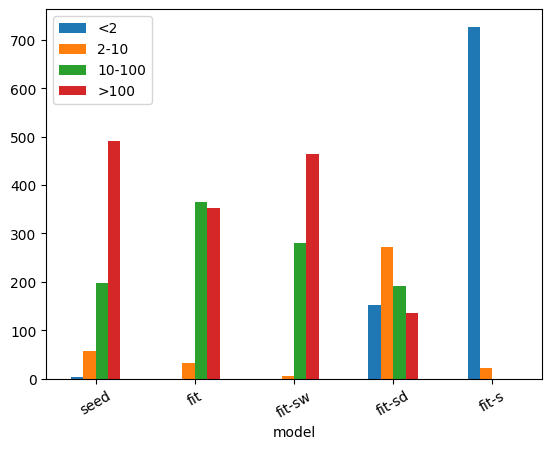

In [23]:
%matplotlib inline

countsdf.plot.bar(rot=30);

In [24]:
for method in ["seedbased", "fitted", "fitted_seedwords", "fitted_seeddims", "combined"]:
    numentries = res_df[res_df.method == method].shape[0]
    lt2 = res_df[(res_df.method == method) & (res_df.mse < 2)].shape[0]
    lt10 = res_df[(res_df.method == method) & (res_df.mse < 10)].shape[0]
    print("Model", method, "percentage with MSE<2:", lt2, "of", numentries, "=", round(lt2 / numentries, 4))
    print("\t", "percentage with MSE<10:", lt10, "of", numentries, "=", round(lt10 / numentries, 4))

Model seedbased percentage with MSE<2: 3 of 750 = 0.004
	 percentage with MSE<10: 60 of 750 = 0.08
Model fitted percentage with MSE<2: 0 of 750 = 0.0
	 percentage with MSE<10: 33 of 750 = 0.044
Model fitted_seedwords percentage with MSE<2: 0 of 750 = 0.0
	 percentage with MSE<10: 5 of 750 = 0.0067
Model fitted_seeddims percentage with MSE<2: 152 of 750 = 0.2027
	 percentage with MSE<10: 424 of 750 = 0.5653
Model combined percentage with MSE<2: 727 of 750 = 0.9693
	 percentage with MSE<10: 750 of 750 = 1.0


# Where is the difference?

On the Grand et al object properties, the fitted model with seeds as words and dimensions does considerably better than seed-based dimensions. But when does it do better? Does it do better specifically on cases where the original seed-based dimensions did not do well? Is there any regularity to when this model is preferable? e inspect the "seed-based" and "combined" results among the results computed above.

In [25]:
# select results dictionaries for seedbased and combined methods
results_seed = [r for r in results if r["method"] == "seedbased"]
results_comb = [r for r in results if r["method"] == "combined"]

In [26]:
from collections import defaultdict
import statistics

# given a list of results dictionaries, 
# group them by the given dictionary keys
# return as a dictionary keys -> results dictionaries
def eval_aggregate_by(evals, keylabels):
    bydataset_eval = defaultdict(list)
    
    for e in evals:
        key = tuple([str(e[k]) for k in keylabels])
        bydataset_eval[ key ].append(e)
        
    return bydataset_eval

# given a list of results dictionaries,
# compute mean, median and standard deviation over values for a particular key
def eval_summary_by(evals, keylabel):
    vals = [e[keylabel] for e in evals if e[keylabel] is not None]
    
    return (statistics.mean(vals), statistics.median(vals), statistics.stdev(vals))

In [27]:
# for seedbased and combined,
# aggregate results by condition,
# yielding a dictionary mapping (category, feature) to evaluation results
results_seed_bycond = eval_aggregate_by(results_seed, ["category", "feature"])
results_comb_bycond = eval_aggregate_by(results_comb, ["category", "feature"])

In [28]:
# combine into a list of dictionaries, one per condition

In [29]:
seed_and_comb_list = [ ]
for condition in results_seed_bycond.keys():
    category, feature = condition
    
    # keep mean OCP, median MSE only
    rs = results_seed_bycond[condition]
    ocp_seed = eval_summary_by(rs, "ocp")[0]
    mse_seed = eval_summary_by(rs, "mse")[1]
                               
    rs = results_comb_bycond[condition]
    ocp_comb = eval_summary_by(rs, "ocp")[0]
    mse_comb = eval_summary_by(rs, "mse")[1]
    
    seed_and_comb_list.append({ "category":category, "feature":feature,
                                "ocp_seed" : ocp_seed, "mse_seed" : mse_seed,
                                "ocp_comb" : ocp_comb, "mse_comb" : mse_comb})
                                

In [30]:
df = pd.DataFrame(seed_and_comb_list)
df.head()

,category,feature,ocp_seed,mse_seed,ocp_comb,mse_comb
0,cities,temperature,0.528671,5462.512409,0.638749,2.177147
1,professions,intelligence,0.633854,191.445955,0.843547,0.477829
2,clothing,location,0.590434,150.005728,0.812696,0.638092
3,cities,arousal,0.466753,24482.917373,0.820140,0.582723
4,clothing,arousal,0.550581,4390.885257,0.652038,1.744142


In [31]:
# in what percentage of cases did ocp get better?
print("How often did OCP rise from seed-based to fit-s?")
print(df[df.ocp_comb > df.ocp_seed].shape[0], "out of", df.shape[0],
      " -- percentage:", round(df[df.ocp_comb > df.ocp_seed].shape[0] / df.shape[0], 3))

How often did OCP rise from seed-based to fit-s?
50 out of 50  -- percentage: 1.0


In [32]:
# how strongly did ocp rise for different bins of
# ocp in seed-based?
# It does indeed rise the most for the cases where the seed-based results were weakest

# rise in ocp

df["ocp_rise"] = df.ocp_comb - df.ocp_seed

df["ocp_seed_bin"] = pd.cut(df.ocp_seed, 5)
df.groupby(by = "ocp_seed_bin").ocp_rise.mean()

ocp_seed_bin
(0.458, 0.542]    0.273785
(0.542, 0.625]    0.178529
(0.625, 0.707]    0.160629
(0.707, 0.79]     0.086496
(0.79, 0.873]     0.017504
Name: ocp_rise, dtype: float64

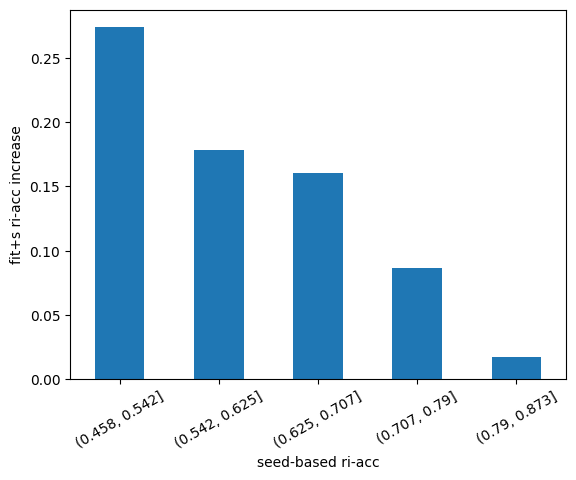

In [33]:
df.groupby(by = "ocp_seed_bin").ocp_rise.mean().plot.bar(rot=30 ,xlabel="seed-based ri-acc", ylabel="fit+s ri-acc increase");

# Printing out all the results in a table, to choose from for the paper

In [34]:
# combine all results into one dictionary per condition

results_seed_bycond = eval_aggregate_by([r for r in results if r["method"] == "seedbased"], ["category", "feature"])
results_fit_bycond = eval_aggregate_by([r for r in results if r["method"] == "fitted"], ["category", "feature"])
results_fitsw_bycond = eval_aggregate_by([r for r in results if r["method"] == "fitted_seedwords"], ["category", "feature"])
results_fitsd_bycond = eval_aggregate_by([r for r in results if r["method"] == "fitted_seeddims"], ["category", "feature"])
results_fits_bycond = eval_aggregate_by([r for r in results if r["method"] == "combined"], ["category", "feature"])

resultdict_list = [ ]
for condition in results_seed_bycond.keys():
    category, feature = condition
    
    e = { "category":category, "feature":feature, "ocp":{}, "mse" : {} }
    
    # keep mean OCP, median MSE only
    rs = results_seed_bycond[condition]
    e["ocp"]["seed"] = eval_summary_by(rs, "ocp")[0]
    e["mse"]["seed"] = eval_summary_by(rs, "mse")[1]
                               
    rs = results_fit_bycond[condition]
    e["ocp"]["fit"] = eval_summary_by(rs, "ocp")[0]
    e["mse"]["fit"] = eval_summary_by(rs, "mse")[1]
    
    rs = results_fitsw_bycond[condition]
    e["ocp"]["fit-sw"] = eval_summary_by(rs, "ocp")[0]
    e["mse"]["fit-sw"] = eval_summary_by(rs, "mse")[1]
    
    rs = results_fitsd_bycond[condition]
    e["ocp"]["fit-sd"] = eval_summary_by(rs, "ocp")[0]
    e["mse"]["fit-sd"] = eval_summary_by(rs, "mse")[1]
    
    rs = results_fits_bycond[condition]
    e["ocp"]["fit-s"] = eval_summary_by(rs, "ocp")[0]
    e["mse"]["fit-s"] = eval_summary_by(rs, "mse")[1]
    
    resultdict_list.append(e)


In [35]:
# make a LaTeX table (minus header)
# category feature, ocp's, mse's
# for results it's always first seed, then fit, then fit-sw, fit-sd, fit-s
# for now, sort by seed ocp
for e in sorted(resultdict_list, key = lambda d:d["ocp"]["seed"]):
    print(e["category"], "&", e["feature"], "&", end = " ")
    models = ["seed", "fit", "fit-sw", "fit-sd", "fit-s"]
    for m in models:
        print(round(e["ocp"][m],2), "&", end = " ")
    for m in models:
        print(round(e["mse"][m], 2), "&", end = " ")
    print("\\\\")

sports & speed & 0.46 & 0.55 & 0.56 & 0.52 & 0.78 & 7095.35 & 54.75 & 93.83 & 94.98 & 1.07 & \\
states & cost & 0.46 & 0.5 & 0.5 & 0.42 & 0.83 & 23948.33 & 113.11 & 158.52 & 848.46 & 0.59 & \\
cities & arousal & 0.47 & 0.52 & 0.5 & 0.51 & 0.82 & 24482.92 & 224.36 & 379.4 & 175.49 & 0.58 & \\
animals & intelligence & 0.48 & 0.55 & 0.54 & 0.5 & 0.79 & 4299.24 & 38.39 & 150.45 & 66.51 & 0.66 & \\
clothing & cost & 0.48 & 0.52 & 0.51 & 0.55 & 0.76 & 1208.91 & 166.41 & 112.79 & 53.38 & 0.96 & \\
states & religiosity & 0.5 & 0.51 & 0.52 & 0.54 & 0.82 & 5887.5 & 44.69 & 108.66 & 337.02 & 0.59 & \\
animals & loudness & 0.5 & 0.52 & 0.52 & 0.59 & 0.78 & 18387.79 & 90.17 & 102.13 & 14.25 & 0.81 & \\
clothing & size & 0.53 & 0.53 & 0.53 & 0.52 & 0.64 & 3210.0 & 96.45 & 100.03 & 191.57 & 1.37 & \\
cities & temperature & 0.53 & 0.59 & 0.58 & 0.5 & 0.64 & 5462.51 & 28.93 & 139.61 & 721.18 & 2.18 & \\
cities & cost & 0.54 & 0.57 & 0.51 & 0.54 & 0.81 & 7587.94 & 182.42 & 418.78 & 54.71 & 0.75 & \\
clo